In [1]:
import torch
import torchvision
import gudhi as gd
from gudhi.wasserstein import wasserstein_distance

from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
%matplotlib inline

from ripser import lower_star_img
from ripser import Rips

import persim
import diagram2vec

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F

import gudhi as gd
from gudhi.wasserstein import wasserstein_distance as dist_w

from IPython.display import clear_output

POT (Python Optimal Transport) package is not installed. Try to run $ conda install -c conda-forge pot ; or $ pip install POT


In [2]:
mnist = loadmat("../data/mnist/mnist-original.mat")
X = mnist["data"].T
y = mnist["label"][0]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
img = X_train[0].reshape(28, 28) / 255

In [174]:
def diagram(image, sublevel=True):
    # get height and square image
    h = int(np.sqrt(image.shape[0]))
    image_sq = image.reshape((h,h))

    # create complex
    cmplx = gd.CubicalComplex(dimensions=(h, h), top_dimensional_cells=(sublevel*image))

    # get pairs of critical simplices
    cmplx.compute_persistence()
    critical_pairs = cmplx.cofaces_of_persistence_pairs()
    
    # get essential critical pixel
    bpx0_essential = critical_pairs[1][0][0] // h, critical_pairs[1][0][0] % h

    # get critical pixels corresponding to critical simplices
    try:
        bpx0 = [critical_pairs[0][0][i][0] for i in range(len(critical_pairs[0][0]))]
        dpx0 = [critical_pairs[0][0][i][1] for i in range(len(critical_pairs[0][0]))]
    except IndexError:
        bpx0 = [[]]
        dpx0 = [[]]
        
    try:
        bpx1 = [critical_pairs[0][1][i][0] for i in range(len(critical_pairs[0][1]))]
        dpx1 = [critical_pairs[0][1][i][1] for i in range(len(critical_pairs[0][1]))]
    except IndexError:
        bpx1 = [[]]
        dpx1 = [[]]
    

    flat_image = image_sq.flatten()
    pd0_essential = torch.tensor([[image_sq[bpx0_essential], torch.max(image)]])

    if (len(bpx0)!=0):
        pdb0 = flat_image[bpx0][:, None]
        pdd0 = flat_image[dpx0][:, None]
        pd0 = torch.Tensor(np.hstack([pdb0, pdd0]))
        pd0 = torch.vstack([pd0, pd0_essential])
    else:
        pd0 = pd0_essential

    if (len(bpx1)!=0):
        pdb1 = flat_image[bpx1][:, None]
        pdd1 = flat_image[dpx1][:, None]
        pd1 = torch.Tensor(np.hstack([pdb1, pdd1]))
    else:
        pd1 = torch.zeros((1, 2))
    
    return pd0, pd1

In [184]:
def process_by_direction(img, alpha):
    X = (math.cos(alpha) - (np.arange(0, img.shape[0]) - (img.shape[0] / 2 - 0.5)) / (img.shape[0] * math.sqrt(2))) * math.cos(alpha) / 2
    Y = (math.sin(alpha) - (np.arange(0, img.shape[1]) - (img.shape[1] / 2 - 0.5)) / (img.shape[1] * math.sqrt(2))) * math.sin(alpha) / 2
    direction_filter = X.reshape(-1, 1) + Y.reshape(1, -1)
    return np.maximum(direction_filter, img)

def process_image(img, filter_params):
    imgs = [process_by_direction(img.reshape(28, 28), alpha) for alpha in filter_params]
    diagrams = []
    for i, img in enumerate(imgs):
        res = diagram(torch.Tensor(img.flatten()))
        for j in range(len(res)):
            diagrams.append(torch.concatenate([res[j], torch.Tensor([[j, filter_params[i]] for _ in range(res[j].shape[0])])], axis=1))

    diagrams = torch.concatenate(diagrams)
    return diagrams

def process_by_conv(img, conv):
    img = conv(torch.Tensor(img).reshape(1, 28, 28)).detach()
    diagrams = []
    for i in range(img.shape[0]):
        res = diagram(img[i].flatten())
        for j in range(len(res)):
            diagrams.append(torch.concatenate([res[j], torch.Tensor([[j, i] for _ in range(res[j].shape[0])])], axis=1))
    diagrams = torch.concatenate(diagrams)
    return diagrams


In [186]:
class MyDatasetDirection(torch.utils.data.Dataset):
    def __init__(self, X, y, filter_params):
        self.X = [
            process_image(x / 255, filter_params).numpy() for x in tqdm(X)
        ]
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class MyDatasetConv(torch.utils.data.Dataset):
    def __init__(self, X, y, conv):
        with torch.no_grad():
            self.X = [
                process_by_conv(x / 255, conv).detach().numpy() for x in tqdm(X)
            ]
            self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def collate_fn_fixed(data, points_count):
    tmp_pd, _ = data[0]

    n_batch = len(data)
    n_features_pd = tmp_pd.shape[1]
    n_points_pd = points_count
    inputs_pd = np.zeros((n_batch, n_points_pd, n_features_pd), dtype=float)
    labels = np.zeros(len(data))

    for i, (pd, label) in enumerate(data):
        inputs_pd[i][:len(pd)] = pd
        labels[i] = label

    return torch.Tensor(inputs_pd), torch.Tensor(labels).long()

In [ ]:
train_dataset1 = MyDataset(X_train, y_trai)
test_dataset1 = MyDataset(X_test, y_tes)

train_dataset4 = MyDataset(X_train, y_trai)
test_dataset4 = MyDataset(X_test, y_tes)

train_dataset10 = MyDataset(X_t, y_train)
test_dataset10 = MyDataset(X_test, y_test)

In [187]:
torch.manual_seed(42)
conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)

torch.manual_seed(43)
conv4 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3)

torch.manual_seed(44)
conv10 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3)

train_conv_dataset1 = MyDatasetConv(X_train, y_train, conv1)
test_conv_dataset1 = MyDatasetConv(X_test, y_test, conv1)

train_conv_dataset4 = MyDatasetConv(X_train, y_train, conv4)
test_conv_dataset4 = MyDatasetConv(X_test, y_test, conv4)

train_conv_dataset10 = MyDatasetConv(X_train, y_train, conv10)
test_conv_dataset10 = MyDatasetConv(X_test, y_test, conv10)

100%|██████████| 14000/14000 [02:31<00:00, 92.65it/s]


In [191]:
train_dataset = torch.load('../data/mnist/1_conv_filter_train.pt')
test_dataset = torch.load('../data/mnist/1_conv_filter_test.pt')

In [192]:
class Transformer(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out, seq_size=1024):
        super(Transformer, self).__init__()
        self.embeddings = nn.Linear(n_in, n_hidden)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=n_hidden, nhead=2, dim_feedforward=16, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer=self.encoder_layer, num_layers=2)
        self.classifier = nn.Linear(seq_size, n_out)

    def forward(self, X):
        X = self.embeddings(X)
        X = self.transformer(X)
        X = X.mean(dim=2)
        X = self.classifier(X)
        X = X.softmax(dim=-1)
        return X


class LinearModel(torch.nn.Module):
    def __init__(self, n_in, n_out):
        super(LinearModel, self).__init__()
        self.ll1 = nn.Linear(n_in, n_in // 2)
        self.ll2 = nn.Linear(n_in // 2, n_in // 16)
        self.ll3 = nn.Linear(n_in // 16, n_out)

    def forward(self, X):
        X = X.reshape(-1, X.shape[-1] * X.shape[-2])
        X = self.ll1(X)
        X = F.relu(X)
        X = self.ll2(X)
        X = F.relu(X)
        X = self.ll3(X)
        X = F.softmax(X)
        return X

In [193]:
CLASS_NUM = 10

def fit(train_dataloader, test_dataloader, model, criterion, optimizer, epochs):
    best_model = deepcopy(model)
    best_loss = np.inf
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    for epoch in range(epochs):
        model.train()
        cur_train_loss = []
        cur_test_loss = []
        cur_train_accuracy = []
        cur_test_accuracy = []
        for batch in tqdm(train_dataloader):
            optimizer.zero_grad()
            target = batch[1].to(device)
            output = model(batch[0].to(device))
            loss = criterion(output, F.one_hot(target, CLASS_NUM).float())
            loss.backward()
            optimizer.step()
            cur_train_loss.append(loss.item())
            cur_train_accuracy.append((output.argmax(-1) == target).float().mean().item())

        with torch.no_grad():
            for batch in tqdm(test_dataloader):
                target = batch[1].to(device)
                output = model(batch[0].to(device))
                loss = criterion(output, F.one_hot(target, CLASS_NUM).float())
                cur_test_loss.append(loss.item())
                cur_test_accuracy.append((output.argmax(-1) == target).float().mean().item())

        clear_output()

        train_losses.append(np.mean(np.array(cur_train_loss)))
        test_losses.append(np.mean(np.array(cur_test_loss)))
        train_accuracies.append(np.mean(np.array(cur_train_accuracy)))
        test_accuracies.append(np.mean(np.array(cur_test_accuracy)))

        print(f'{epoch}: train_accuracy={train_accuracies[-1]}, test_accuracy={test_accuracies[-1]}, train_loss={train_losses[-1]}, test_loss={test_losses[-1]}')
        if test_losses[-1] < best_loss:
            print(f'Save the new best model')
            best_model = deepcopy(model)
            best_loss = test_losses[-1]

        plt.subplot(1, 2, 1)
        plt.plot(np.arange(epoch+1), test_accuracies, label='test_accuracy')
        plt.plot(np.arange(epoch+1), train_accuracies, label='train_accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(np.arange(epoch+1), test_losses, label='test_loss')
        plt.plot(np.arange(epoch+1), train_losses, label='train_loss')
        plt.legend()

        plt.show()
    return best_model

In [194]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)

mps


In [195]:
max_value = 0
for el in train_dataset:
    max_value = max(max_value, el[0].shape[0])
print(max_value)

68


3: train_accuracy=0.411375, test_accuracy=0.4305793378995434, train_loss=0.23931560525723866, test_loss=0.23294691567959852
Save the new best model


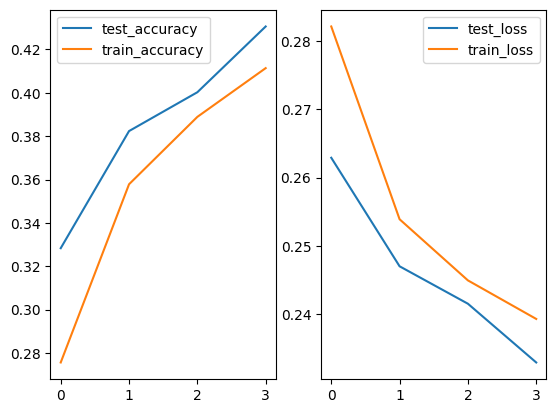

 17%|█▋        | 297/1750 [00:05<00:27, 53.75it/s]


KeyboardInterrupt: 

In [196]:
# With transformer

batch_size = 32

collate_fn_fixed128 = lambda x: collate_fn_fixed(x, 128)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_fixed128)
test_dataloader =  DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_fixed128)

model = Transformer(n_in=4, n_hidden=8, n_out=10, seq_size=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))
criterion = nn.BCELoss()
best_model = fit(train_dataloader, test_dataloader, model, criterion, optimizer, 100)

99: train_accuracy=0.5792857142857143, test_accuracy=0.5849029680365296, train_loss=0.1925458785380636, test_loss=0.1912564463471169


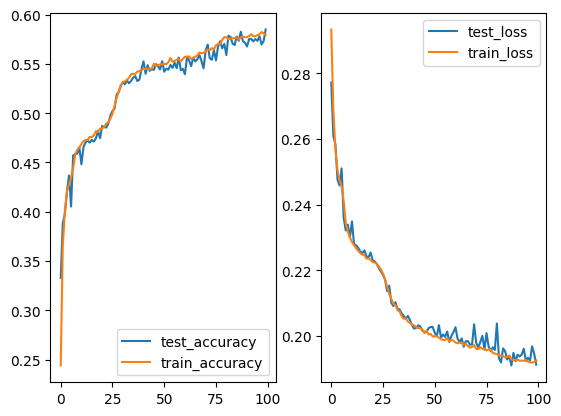

In [30]:
# With transformer

batch_size = 32

collate_fn_fixed128 = lambda x: collate_fn_fixed(x, 128)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_fixed128)
test_dataloader =  DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_fixed128)

model = Transformer(n_in=4, n_out=10, seq_size=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))
criterion = nn.BCELoss()
best_model = fit(train_dataloader, test_dataloader, model, criterion, optimizer, 100)

In [34]:
train_dataset4 = torch.load('../data/mnist/4_filter_train.pt')
test_dataset4 = torch.load('../data/mnist/4_filter_test.pt')

In [35]:
max_value = 0
for el in train_dataset4:
    max_value = max(max_value, el[0].shape[0])
print(max_value)

309


99: train_accuracy=0.7076785714285714, test_accuracy=0.7022142857142857, train_loss=0.1453003657778193, test_loss=0.14502616155147552


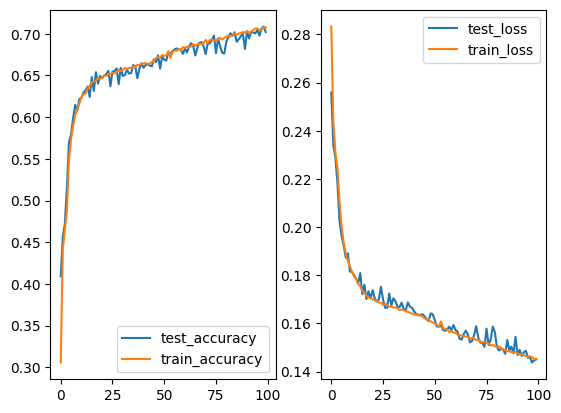

In [36]:
# With transformer (4 filters)

batch_size = 8

collate_fn_fixed512 = lambda x: collate_fn_fixed(x, 512)

train_dataloader = DataLoader(train_dataset4, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_fixed512)
test_dataloader =  DataLoader(test_dataset4, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_fixed512)

model = Transformer(n_in=4, n_out=10, seq_size=512).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))
criterion = nn.BCELoss()
best_model = fit(train_dataloader, test_dataloader, model, criterion, optimizer, 100)